In [1]:
import pandas as pd
import numpy as np

import cv2 as cv
# from sklearn.preprocessing import LabelEncoder
import pickle
from keras_facenet import FaceNet
from mtcnn.mtcnn import MTCNN
from PIL import Image
from datetime import datetime

In [2]:
with open("../packages/model.pkl", 'rb') as f:
    model = pickle.load(f)
with open("../packages/encoder.pkl", 'rb') as f:
    encoder = pickle.load(f)

In [3]:
detector = MTCNN()
embedder = FaceNet()
# faces_embeddings = np.load("embeddings.npz")
# Y = faces_embeddings['labels']
threshold = 0.2

In [4]:
def get_embeddings(face_img):
    face_img = np.expand_dims(face_img, axis=0)
    embedding = embedder.embeddings(face_img)
    embedding = embedding[0]
    return embedding

In [5]:
def load_image(image_path):
    image = cv.imread(image_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    return image

In [6]:
def extract_faces(img):
    img = load_image(img)
    faces = detector.detect_faces(img)
    embeddings = []
    boxes = []
    if faces:
        for face in faces:
            box = face['box']
            x, y, w, h = box
            face_img = img[y:y+h, x:x+w]
            face_img = cv.resize(face_img, (160, 160))
            embedding = get_embeddings(face_img)
            embeddings.append(embedding)
            boxes.append(box)
    return embeddings, boxes

In [7]:
def predict(image):
    embeddings, boxes = extract_faces(image)
    predictions = []
    if embeddings:
        for embedding in embeddings:
            proba = model.predict_proba(embedding.reshape(1, -1))
            max_proba = np.argmax(proba)
            if proba[0][max_proba] > threshold:
                predictions.append(encoder.inverse_transform([max_proba])[0])
            else:
                print("Unknown")
                predictions.append("Unknown")   
    return predictions, boxes

In [8]:
def attendance(df, path):
    predictions, boxes = predict(path)
    for prediction in predictions:
        if prediction in df["Name"].values:
            now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            df.loc[df['Name'] == prediction, 'Attendance'] = 'present'
            df.loc[df['Name'] == prediction, 'Time'] = now
        else:
            print("Data Tidak Ditemukan")
    return df, predictions, boxes

In [21]:
df = pd.DataFrame({
        'Name': ["Ahmad Haidar Zaidan Ammar", "Bagus Purboyo", "Faiqah Gusmarianty", 
                 "Falisa Alfiani Heriansyah", "Fhika Fezya Amesha", "Heri Arista",
                 "Jovan Prasetyo Wibisono", "Lutfiah Aulia", "Muhammad Ridho Adriano",
                 "Nafisah Fathimatus Zahra", "Naufal Fadhli Adyatma", "Rafi Amrullah Al-Baihaqi Gunawan",
                 "Rohid Ade Pratama", "Rohmah Mufidah", "Salsabila Azzahra",
                 "Zahrah Salsabila Dhia Ichsandi"],
        'Attendance': [""] * 17,
        'Time': [""] * 17
    })

ValueError: All arrays must be of the same length

In [ ]:
path = "../testing/testing03.jpg"
df, predictions, boxes = attendance(df, path)

1/1 [==============================] - 0s 134ms/step

[[0.09031233 0.02109954 0.06826999 0.04563733 0.08009289 0.13077149
  0.01795915 0.15335092 0.0641045  0.06246879 0.09088925 0.07660755
  0.02238073 0.04049885 0.03555668]]

Unknown

[[0.0847505  0.01500931 0.02512457 0.02572762 0.03063119 0.02360107
  0.02295204 0.07801696 0.0229473  0.04569861 0.53614373 0.02736987
  0.02253118 0.01774585 0.0217502 ]]


[[0.07160678 0.02554435 0.02250651 0.03687721 0.05405915 0.04277457
  0.01942762 0.05069789 0.0456235  0.04631593 0.07504721 0.42697127
  0.0174032  0.04627313 0.01887166]]


[[0.26253134 0.02636636 0.01290414 0.03360406 0.12221286 0.02565738
  0.02747227 0.15419244 0.0210642  0.06385498 0.08641828 0.08783372
  0.02122727 0.03373105 0.02092964]]


[[0.0851425  0.01146475 0.02592664 0.04675107 0.0447501  0.03726701
  0.03425801 0.04967201 0.02930205 0.45033935 0.07388531 0.04345474
  0.03189299 0.02767405 0.00821941]]


[[0.04642408 0.02926712 0.01824569 0.0304706  0.04158034 0.4772

In [ ]:
import matplotlib.pyplot as plt

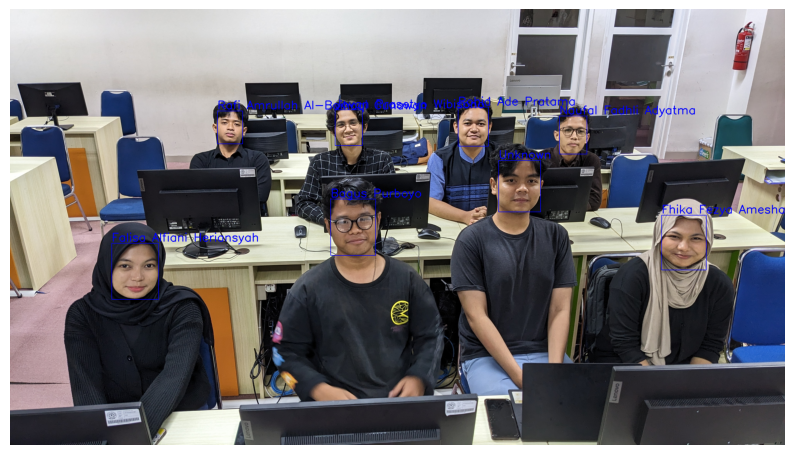

In [20]:
img = load_image(path)
for (box, prediction) in zip(boxes, predictions):
    x, y, w, h = box
    
    cv.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
    cv.putText(img, prediction, (x, y-10), cv.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 3)
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(img)

In [14]:
df.head(20)

,Name,Attendance,Time
0,Ahmad Haidar Zaidan Ammar,,
1,Bagus Purboyo,present,2024-07-22 18:43:11
2,Faiqah Gusmarianty,,
3,Falisa Alfiani Heriansyah,present,2024-07-22 18:43:11
4,Fhika Fezya Amesha,present,2024-07-22 18:43:11
5,Heri Arista,,
6,Jovan Prasetyo Wibisono,present,2024-07-22 18:43:11
7,Lutfiah Aulia,,
8,Muhammad Ridho Adriano,,
9,Nafisah Fathimatus Zahra,,
